<img src='https://www.dropbox.com/s/125k1wnxkl6bgs0/class_logo.jpg?dl=1' alt="Smiley face" align="center" style="width: 600px;"/>

# Notebook 6 A





### Topics covered
* * *
 * What is a valid trading strategy?
 * Quantitative trading strategies
 * Constructing a trading strategy
     * Signals->weights-> strategy returns
 * Timing Strategies
    * Continuation
    * Volatility timing


# What is a valid trading strategy?

* A trading strategy is a procedure that maps any information known up to time t, into a set of trading instructions for time  $T>t$.

* The weights of a trading strategy must either:
   * Add up to 1. So it describes what you do with your entire capital.
   * Or add up to 0. So the strategy is self-financing. For example, borrow 1 dollar at the risk-free rate and buy 1 dollar worth of the market portfolio
   * Every time you trade on the excess returns, you can think of the weights "adding up to zero"

* It is very important that the trading strategy only uses information that is known at the time of the trade, otherwise it is not a valid trading strategy-- you obviously cannot trade on info that you don't know

* It is very important that you are clear about where the dollars that you invest come from, so that the weights can add up to 1 (if you have some capital) or zero (if the strategy is self-financed and demand zero capital).

  * In practice all strategies demand capital as no bank allow us to borrow without putting some capital in, but these self financed strategies are quite convenient to work with as they are all in the "Excess Return Space" since they have zero cost. 
  
  * If you don't know what I am talking about, go back to notebook 3, 4 and 5.

* Example of a VALID trading strategy: Every monday buy stocks that had positive news coverage during the weekend and sell stocks that had negative news coverage.
  * This is valid because you are trading after the information is known.

* Example of INVALID trading strategy: On Friday buy all the stocks that will have positive news coverage during the weekend, and sell all the stocks that will have negative coverage during the weekend.

   * This is Invalid because you are trading before the information is known.
   
* This might sound ridicoulous. Obviously you can not trade on the information that is not known at the time of the trade!

* But note that we will be "simulating" the trading process using HISTORICAL data, so we can easily get confused and use "future" information in the strategy construction process.




# Quantitative trading strategies

* In this class we will focus on quantitative trading strategies. 

* Stragies that get some hard data about one or multiple assets and transform this data "mechanically"  into  portfolio weights

* So given data $X_{t}$, a quatitative trading strategy is a function that maps data into weights $W_{t+1}=f(X_t)$

* Example of "Market Timing" 1: Betting on the "market momentum"
  * If months t, t-1 and t-2 the market had postive returns in each of the months, then buy 1 dollar at the closing price of month t and sell and the closing price of month t+1
  
  * Otherwise invest in the risk-free asset

* Example of "Market Timing" 2: Volatility timing
  * Using daily data for month t, construct the market return "realized variance" during month t
   
   $$RV_t=\sum_{d \in days~ in ~month ~t}\frac{(R_d- \overline{R})^2}{N_{days}},$$
   
      where $\overline{R}$ is the average return within the month
   
  * Buy stocks at the closing price of month t accoding to the rule:
   
   $$W_t=\frac{c}{RV_t},$$
   
      where $c$ is some constant.
   
  * Hold for a month
   
*    Example of "cross-sectional" strategy 1: Betting on the short-term reversal across industries
       
  * Sort portfolios of industries by their close to close returns in month t.
    
  * Buy the botton  10% , short the top 10% 
    
  * Hold for a month

   
*    Example of "cross-sectional" strategy 2: Betting on the volatility across stocks
       
       * Construct stock realized variance in the last 24 months
       
       * Sort stocks by realized variance
       
       * Buy the bottom 10%, short the top 10%
       
       * Hold for a month


>All these strategies map past data into a trading rule
  * This allows us to backtest the strategy and see how it would have performed in a variety of investment conditions
  * This ability to look back is the essential feature of quantitative investing



## Market Timing: Betting on continuation



### Construct our first trading strategy

In [19]:
# start by loading data on the returns of the market portfolio and the risk-free rate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:

#GlobalFinMonthly
url="https://www.dropbox.com/s/3k35mt3t57ygff2/GlobalFinMonthly.csv?dl=1"
Data = pd.read_csv(url,na_values=-99)
# tell python Date is date:
Data['Date']=pd.to_datetime(Data['Date'])
# set an an index
Data=Data.set_index(['Date'])
Data=Data.rename(columns={Data.columns[1]: "MKTUS",Data.columns[2]: "BondUS",
                          Data.columns[3]: "EM",Data.columns[4]: "MKTxUS",Data.columns[5]: "BondxUS" })
Data=Data[['RF','MKTUS']]
Data.head()

,RF,MKTUS
Date,,
1963-02-28,0.0023,-0.0215
1963-03-31,0.0023,0.0331
1963-04-30,0.0025,0.0476
1963-05-31,0.0024,0.0200
1963-06-30,0.0023,-0.0177


We start by constructing  the timing strategy 1: Buy if market went up for three consecutive months

In [22]:
Data.MKTUS.tail(10)

Date
2016-03-31    0.0698
2016-04-30    0.0093
2016-05-31    0.0179
2016-06-30   -0.0003
2016-07-31    0.0397
2016-08-31    0.0052
2016-09-30    0.0027
2016-10-31   -0.0200
2016-11-30    0.0487
2016-12-31    0.0185
Name: MKTUS, dtype: float64

In [24]:
# We use .shift(1) to lag the data by 1 period
Data.MKTUS.shift(1).tail(10)

Date
2016-03-31   -0.0005
2016-04-30    0.0698
2016-05-31    0.0093
2016-06-30    0.0179
2016-07-31   -0.0003
2016-08-31    0.0397
2016-09-30    0.0052
2016-10-31    0.0027
2016-11-30   -0.0200
2016-12-31    0.0487
Name: MKTUS, dtype: float64

In [25]:
Data['Wmkt']=1*((Data.MKTUS.shift(1)>0) & (Data.MKTUS.shift(2)>0) & (Data.MKTUS.shift(3)>0))
Data['Wrf']=1-Data.Wmkt
Data.head(10)

,RF,MKTUS,Wmkt,Wrf
Date,,,,
1963-02-28,0.0023,-0.0215,0,1
1963-03-31,0.0023,0.0331,0,1
1963-04-30,0.0025,0.0476,0,1
1963-05-31,0.0024,0.0200,0,1
1963-06-30,0.0023,-0.0177,1,0
1963-07-31,0.0027,-0.0012,0,1
1963-08-31,0.0025,0.0532,0,1
1963-09-30,0.0027,-0.0130,0,1
1963-10-31,0.0029,0.0282,0,1


* So this is our first quant strategy.

  * It gets data on returns and transforms into a portfolio 

  * Importantly, the weight that you have one the market at date t, only depends on data that is know before date t

  * So this is a valid trading strategy

* Is it a good one? 

### Evaluate our first quant strategy

First step is to look at it's realized returns:

* We will name it $\textbf{MFQS}$ (My First Quant Strategy)

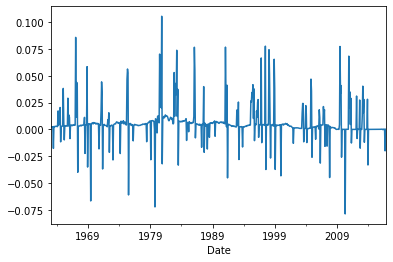

In [26]:
# Plot the average return of MFQS in time series
Data['MFQS']=Data.RF*Data.Wrf+Data.MKTUS*Data.Wmkt
Data.MFQS.plot()
plt.show()

* Why sometimes the strategy is totally flat?

* how does it compare with the market?

In [29]:
# Look at average returns for the US market and our MFQS strategy
Data[['MKTUS','MFQS']].mean()


MKTUS    0.009052
MFQS     0.005750
dtype: float64

In [28]:
# Look at volatilities for the US market and our MFQS strategy
Data[['MKTUS','MFQS']].std()

MKTUS    0.044003
MFQS     0.016796
dtype: float64

Both average return and volatility of `MFQS' are lower than the US market

> Is it surprising?

> Does it mean that someone that is more risk-averse than the average investor can benefit from investing in MFQS?


Looking at cumulative returns:



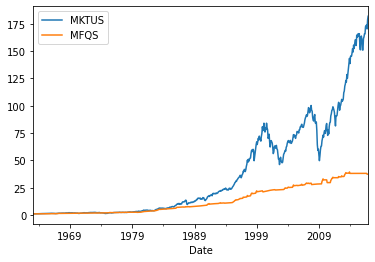

In [27]:
(Data[['MKTUS','MFQS']]+1).cumprod().plot()
plt.show()

Lets look at Sharpe Ratios. 

> How do we construct it?

> How do we annualize?

In [30]:
Data[['MKTUS','MFQS']].subtract(Data.RF,axis=0).mean()/Data[['MKTUS','MFQS']].std()*12**0.5

MKTUS    0.404668
MFQS     0.379282
dtype: float64

* Does this mean that MFQS is a bad idea?

* What does this mean for a mean-variance investor that can borrow and lend at the risk-free rate and must choose between investing in the risk-free and the market or the risk-free and MFQS?

* Is there a degree of risk aversion that would make the investor prefer MFQS over the Market?

* What if the investor could invest in all three assets? would he ever invest in MFQS?

## Volatility timing: A more sophisitcated timing strategy


* You guys learned in 411 that a mean-variance investor invests in the risky asset proportionally to the risk-return trade-off

$$W_t=\frac{\mu_t}{\gamma \sigma_t^2}$$

* Measuring variation in $\mu_t$, the expected excess return on the market is really hard 

   * There are theoretically motivated ways to do it, which we will discuss later, but they are not great empirically

* But measuring variaiton in volatility is much easier because volatility periods tend to cluster together

* Lets download daily stock market data to show this visually

### Download data from WRDS

* We can download data directly from the WRDS (Wharton Reseach Data Services ) server

* If you want you can get a login to get acess to it as well. All you need is to follow the steps

https://wrds-web.wharton.upenn.edu/wrds/?register=1

* Anyone doing serious quant work needs a way to get a lot of data quickly. 

* WRDS has plenty of the basic data sources

In [ ]:
# install packages
!pip install wrds
!pip install psycopg2

In [32]:
import datetime as dt
import wrds
import psycopg2 
from dateutil.relativedelta import *


# connect with their server
conn=wrds.Connection()

# get the value-weighted market returns and date from the data base crsp.dsi
mkt_d = conn.raw_sql("""
                      select a.date, a.vwretd
                      from crsp.dsi as a
                      """) 
# get the risk-free rate
rf_d = conn.raw_sql("""
                      select a.date, a.rf
                      from ff.factors_daily as a
                      """)
# save data locally
#rf_d.to_csv('E:/Dropbox/Public/Fin418/Data/rf_d.csv')
#mkt_d.to_csv('E:/Dropbox/Public/Fin418/Data/mk_d.csv')

Enter your WRDS username [Alan Moreira]:moreira5
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.


Exception during reset or similar
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\engine\default.py", line 543, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.



Loading library list...
Done


In [31]:
# alternatively simply import from dropbox or download from blackboard as usual

rf_d=pd.read_csv('https://www.dropbox.com/s/85n50ul6of2fsca/rf_d.csv?dl=1')
mk_d=pd.read_csv('https://www.dropbox.com/s/ns191hnic5gpx13/mk_d.csv?dl=1')

In [33]:
mkt_d.tail()

,date,vwretd
24788,2019-12-24,0.000379
24789,2019-12-26,0.004618
24790,2019-12-27,-0.000643
24791,2019-12-30,-0.005108
24792,2019-12-31,0.002965


In [34]:
rf_d.tail()

,date,rf
24849,2020-10-26,0.0
24850,2020-10-27,0.0
24851,2020-10-28,0.0
24852,2020-10-29,0.0
24853,2020-10-30,0.0


In [35]:
# this set the index
mkt_d=mkt_d.set_index(['date'])

mkt_d=mkt_d.set_index(pd.to_datetime(mkt_d.index),'date')

rf_d=rf_d.set_index(['date'])

rf_d=rf_d.set_index(pd.to_datetime(rf_d.index),'date')

# we merge

daily=mkt_d.merge(rf_d,how='left',left_index=True,right_index=True)
daily.tail()

,vwretd,rf
date,,
2019-12-24,0.000379,0.00007
2019-12-26,0.004618,0.00007
2019-12-27,-0.000643,0.00007
2019-12-30,-0.005108,0.00007
2019-12-31,0.002965,0.00007


### We have daily data. How to construct monthly realized variance?


You basically use pandas time series function that shifts all dates to the end of the month, so this way you are technically grouping by the end of the month day.

In [39]:
daily.index

DatetimeIndex(['1925-12-31', '1926-01-02', '1926-01-04', '1926-01-05',
               '1926-01-06', '1926-01-07', '1926-01-08', '1926-01-09',
               '1926-01-11', '1926-01-12',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='date', length=24793, freq=None)

In [38]:
daily.index+MonthEnd(0)

DatetimeIndex(['1925-12-31', '1926-01-31', '1926-01-31', '1926-01-31',
               '1926-01-31', '1926-01-31', '1926-01-31', '1926-01-31',
               '1926-01-31', '1926-01-31',
               ...
               '2019-12-31', '2019-12-31', '2019-12-31', '2019-12-31',
               '2019-12-31', '2019-12-31', '2019-12-31', '2019-12-31',
               '2019-12-31', '2019-12-31'],
              dtype='datetime64[ns]', name='date', length=24793, freq=None)

In [40]:
from pandas.tseries.offsets import MonthEnd

# We denote `realized variance` for the market return as `RV`
RV=daily[['vwretd']].groupby(daily.index+MonthEnd(0)).var()
# rename column to clarify
RV=RV.rename(columns={'vwretd':'RV'})
RV.tail()

,RV
date,
2019-08-31,0.000187
2019-09-30,0.000031
2019-10-31,0.000061
2019-11-30,0.000014
2019-12-31,0.000020


In [41]:
# Another way to groupby month
RV1=daily[['vwretd']].groupby(pd.Grouper(freq='M')).var()
RV1.tail()

,vwretd
date,
2019-08-31,0.000187
2019-09-30,0.000031
2019-10-31,0.000061
2019-11-30,0.000014
2019-12-31,0.000020


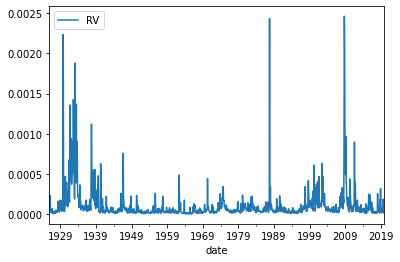

In [42]:
# plot the monthly realized variance
RV.plot()
plt.show()

### From signal to weights

* We now need to do the trading strategy, motivated by the fact that the realized variance in month t is a good proxy for the expected variance in month t+1 (see plot above!)

* So we will form the following strategy:
  * weight on the market:
  $$W_t=c\frac{1}{RV_t}=\frac{\mu}{\gamma RV_t}$$
  * weight on the risk-free rate: $1-W_t$

* $c$ controls how levered is the strategy on average.

* As we saw before all timing strategies involved some in and out of the market, but you also need to determine the average position. That is the role of $c$.

* For example: 
   - Lets set $c$ such that the leverage is 4 when the annualized standard deviation is 4% (which is equivalent to a daily variance of $RV=0.04^2/252$)
   - leverage is $W_t-1$ (you borrow by shorting the risk-free rate)
  $$W_t-1=\frac{c}{RV_t}-1\leq 4$$
   - So $c= 5 RV_t=5*0.04^2/252$

In [54]:
# calculate weights for the risky assets (market)
c=(5*(0.04**2)/252)
RV['W']=c/RV.RV
c

3.1746031746031745e-05

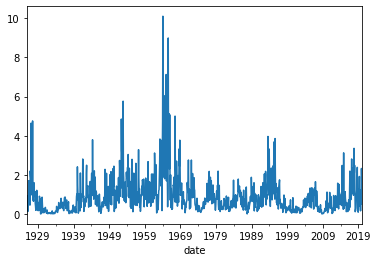

In [51]:
# plot the weights on the risky assets
RV.W.plot()
plt.show()

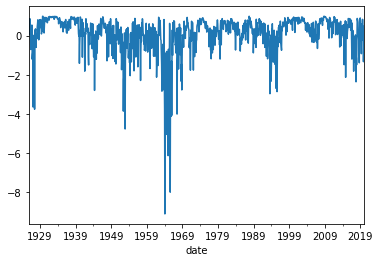

In [45]:
# plot the weights on the risk-free rate
(1-RV.W).plot()
plt.show()

In [53]:
RV.W.mean()

0.9241556985891785

In [56]:
daily

,vwretd,rf
date,,
1925-12-31,NaN,NaN
1926-01-02,0.005689,NaN
1926-01-04,0.000706,NaN
1926-01-05,-0.004821,NaN
1926-01-06,-0.000423,NaN
...,...,...
2019-12-24,0.000379,0.00007
2019-12-26,0.004618,0.00007
2019-12-27,-0.000643,0.00007


### Construct returns to the trategy

#### Aggregate daily returns to monthly

* Since the strategy will trade monthly, we now need to construct monthly returns

* we do that by cumulating daily returns within a month


In [57]:
# aggregate daily returns to monthly returns
Ret=(1+daily).groupby(daily.index+MonthEnd(0)).prod()-1
# rename columns to clarify
Ret=Ret.rename(columns={'vwretd':'Mkt','rf':'Rf'})
Ret.tail()

,Mkt,Rf
date,,
2019-08-31,-0.020256,0.001541
2019-09-30,0.015960,0.001802
2019-10-31,0.019249,0.001611
2019-11-30,0.034953,0.001201
2019-12-31,0.028492,0.001471


In [58]:
RV.tail()

,RV,W
date,,
2019-08-31,0.000187,0.170048
2019-09-30,0.000031,1.036153
2019-10-31,0.000061,0.521629
2019-11-30,0.000014,2.331902
2019-12-31,0.000020,1.594953


In [59]:
# Merge Ret (monthly return) with RV (realized variance and weights)
df=RV.merge(Ret,how='left',left_index=True,right_index=True)
df.tail()

,RV,W,Mkt,Rf
date,,,,
2019-08-31,0.000187,0.170048,-0.020256,0.001541
2019-09-30,0.000031,1.036153,0.015960,0.001802
2019-10-31,0.000061,0.521629,0.019249,0.001611
2019-11-30,0.000014,2.331902,0.034953,0.001201
2019-12-31,0.000020,1.594953,0.028492,0.001471


#### Construct strategy returns

* Now to construct the strategy return recall that we use the relaized variance in month t to buy the market at the closing of month t and earn the return accrued in month t+1

* So we need to lag our weights, or lead the returns

* I will call the strategy as $\textbf{VMS}$ (Volatility Managed Strategy)

In [61]:
df.W

date
1925-12-31         NaN
1926-01-31    0.919672
1926-02-28    0.708324
1926-03-31    0.138235
1926-04-30    0.586952
                ...   
2019-08-31    0.170048
2019-09-30    1.036153
2019-10-31    0.521629
2019-11-30    2.331902
2019-12-31    1.594953
Name: W, Length: 1129, dtype: float64

In [60]:
df.W.shift(1)

date
1925-12-31         NaN
1926-01-31         NaN
1926-02-28    0.919672
1926-03-31    0.708324
1926-04-30    0.138235
                ...   
2019-08-31    1.235581
2019-09-30    0.170048
2019-10-31    1.036153
2019-11-30    0.521629
2019-12-31    2.331902
Name: W, Length: 1129, dtype: float64

In [63]:
df.W.shift(1)+(1-df.W.shift(1))

date
1925-12-31    NaN
1926-01-31    NaN
1926-02-28    1.0
1926-03-31    1.0
1926-04-30    1.0
             ... 
2019-08-31    1.0
2019-09-30    1.0
2019-10-31    1.0
2019-11-30    1.0
2019-12-31    1.0
Name: W, Length: 1129, dtype: float64

In [64]:
df['VMS']=df.W.shift(1)*df.Mkt+(1-df.W.shift(1))*df.Rf

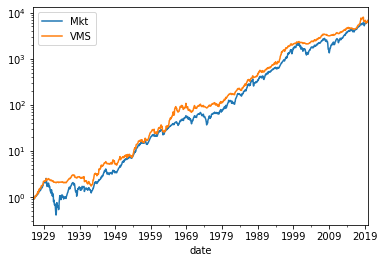

In [65]:
(df[['Mkt','VMS']]+1).cumprod().plot(logy=True)
plt.show()

In [66]:
df[['Mkt','VMS']].mean()

Mkt    0.009239
VMS    0.008606
dtype: float64

In [67]:
df[['Mkt','VMS']].std()

Mkt    0.053142
VMS    0.039161
dtype: float64

Sharpe ratio

In [68]:
(df[['Mkt','VMS']].subtract(df.Rf,axis=0).mean()/df[['Mkt','VMS']].std())*12**0.5

Mkt    0.425594
VMS    0.521141
dtype: float64

Tail risk

In [70]:
df[['Mkt','VMS']].quantile(q=0.005)

Mkt   -0.188058
VMS   -0.134315
Name: 0.005, dtype: float64

* What are other natural measures of risk to look at?

* Does any of this mean that VMS is a good/bad idea?

* What does this mean for a mean-variance investor that can borrow and lend at the risk-free rate and must choose between investing in the risk-free and the market or the risk-free and VMS?

* Is there a degree of risk aversion that would make the investor prefer Market over VMS?

* What if the investor could invest in all three assets? would he ever invest in the market or only on vms?

- This was just an example!

- There are a lot of timing strategies

- I like this one, becuase I (and Tyler Muir) came up with it. (https://www.google.com/url?q=https%3A%2F%2Fwww.dropbox.com%2Fs%2F022escr52x9oe51%2FVolPortfolios_published.pdf%3Fdl%3D0&sa=D&sntz=1&usg=AFQjCNGMECt2zp77lDfZRGJlkXQbGmqn1A)

